In [1]:
import glob
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pyproj import Proj
import xarray
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import timedelta, datetime
from global_land_mask import globe

In [2]:
import psutil

# Get the available memory in bytes
available_memory = psutil.virtual_memory().available
# Convert to gigabytes for easier interpretation
available_memory_gb = available_memory / (1024 ** 3)

print(f"Available memory: {available_memory_gb:.2f} GB")

Available memory: 180.82 GB


In [3]:
#pip install global-land-mask

In [4]:
qa = "aerdt_aod_qa2"
FILE_AHI_agg = f"/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_{qa}.nc"
C_AHI_agg = xarray.open_dataset(FILE_AHI_agg)
C_AHI_agg

<xarray.Dataset>
Dimensions:    (longitude: 186, latitude: 158)
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15
Data variables:
    aod_Mean   (latitude, longitude) float64 ...

In [5]:
FILE_MUSICAv0_agg = f"/home/svisaga/clavrx/AGGR_HOURLY_2019236_273_0_25deg_camp2ex_MUSICAv0_{qa}.nc"
C_MUSICAv0_agg = xarray.open_dataset(FILE_MUSICAv0_agg)
C_MUSICAv0_agg 


<xarray.Dataset>
Dimensions:  (lat: 158, lon: 186)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2
Data variables:
    AODVIS   (lat, lon) float32 ...

In [6]:
mean_aod = C_AHI_agg['aod_Mean']
mean_aod_model = C_MUSICAv0_agg['AODVIS']

In [7]:
# Ensure NaNs in mean_aod match NaNs in mean_aod_model using a for loop
for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        value = mean_aod.sel(latitude=latitude, longitude=longitude)
        if (value < 0):
            mean_aod.loc[dict(latitude=latitude, longitude=longitude)] = np.nan
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan
        if (np.isnan(value)):
            mean_aod_model.loc[dict(lat=latitude, lon=longitude)] = np.nan

In [8]:
mean_aod_model

<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.26111 , 0.249206, 0.122297, ..., 0.0566  , 0.065361, 0.064997],
       [0.243193, 0.197439, 0.10926 , ..., 0.061133, 0.067204, 0.0729  ],
       [0.192897, 0.124439, 0.09372 , ..., 0.073471, 0.070398, 0.070519]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [9]:
mean_aod_model_ocean = mean_aod_model
mean_aod_ocean = mean_aod

for latitude in mean_aod.latitude:
    for longitude in mean_aod.longitude:
        if not globe.is_land(latitude.item(), longitude.item()):
            mean_aod_model_ocean.loc[dict(lat=latitude, lon=longitude)] = np.nan
            mean_aod_ocean.loc[dict(latitude=latitude, longitude=longitude)] = np.nan

In [10]:
mean_aod_model_ocean

<xarray.DataArray 'AODVIS' (lat: 158, lon: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.26111 , 0.249206, 0.122297, ...,      nan,      nan,      nan],
       [0.243193, 0.197439, 0.10926 , ...,      nan,      nan,      nan],
       [0.192897, 0.124439, 0.09372 , ...,      nan,      nan,      nan]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -19.15 -18.9 -18.65 -18.4 ... 19.4 19.65 19.9 20.15
  * lon      (lon) float32 93.94 94.19 94.44 94.69 ... 139.5 139.7 140.0 140.2

In [11]:
mean_aod_ocean

<xarray.DataArray 'aod_Mean' (latitude: 158, longitude: 186)>
array([[     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       [     nan,      nan,      nan, ...,      nan,      nan,      nan],
       ...,
       [0.301737, 0.181512, 0.101421, ...,      nan,      nan,      nan],
       [0.171845, 0.142799, 0.123632, ...,      nan,      nan,      nan],
       [0.155167, 0.139305, 0.159212, ...,      nan,      nan,      nan]])
Coordinates:
  * longitude  (longitude) float64 93.94 94.19 94.44 94.69 ... 139.7 140.0 140.2
  * latitude   (latitude) float64 -19.15 -18.9 -18.65 -18.4 ... 19.65 19.9 20.15

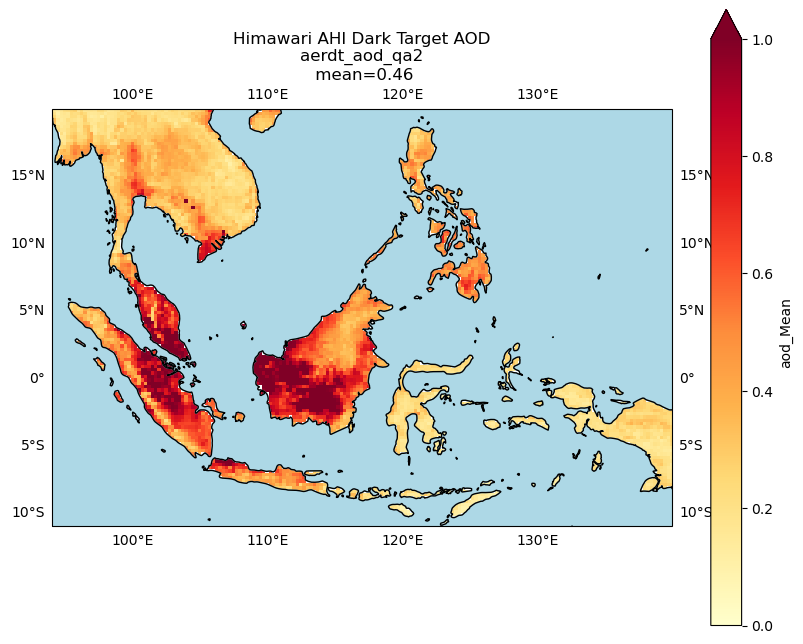

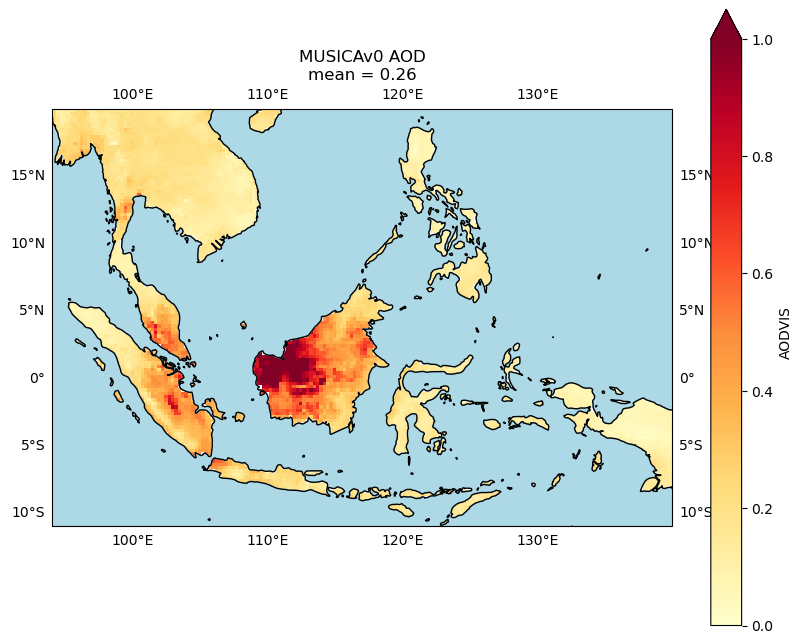

In [13]:
group_name = qa
fig = plt.figure(figsize=(10, 8))
pla_proj = ccrs.PlateCarree()
ax = plt.axes(projection=pla_proj)

longitude_min = 94
longitude_max = 140
latitude_min = -11  # Adjust as necessary
latitude_max = 20   # Adjust as necessary
ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

# Plot the mean_aod_ocean data
mean_aod_ocean.plot.pcolormesh(vmin=0, vmax=1, cmap='YlOrRd', ax=ax)

# Add ocean feature with a specific color
ocean = cf.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor='lightblue')
ax.add_feature(ocean)

ax.coastlines(resolution='50m', color='black', linewidth=1)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False

ahi_mean = mean_aod_ocean.where((mean_aod_ocean.latitude >= -11) & (mean_aod_ocean >=0)).mean().item()
plt.title(f'Himawari AHI Dark Target AOD\n{group_name}\n mean={ahi_mean:.2f}')
plt.savefig(f'img/daily_aod_{group_name}_land.png',dpi=300)
########################################################################
########################################################################
########################################################################
fig = plt.figure(figsize=(10, 8))
pla_proj = ccrs.PlateCarree()
ax = plt.axes(projection=pla_proj)

longitude_min = 94
longitude_max = 140
latitude_min = -11  # Adjust as necessary
latitude_max = 20   # Adjust as necessary
ax.set_extent([longitude_min, longitude_max, latitude_min, latitude_max], crs=ccrs.PlateCarree())

mean_aod_model_ocean.plot.pcolormesh(vmin=0,vmax=1,cmap='YlOrRd')

ax.add_feature(ocean)

ax.coastlines(resolution='50m', color='black', linewidth=1)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.xlines = False
gl.ylines = False

musicav0_mean = mean_aod_model_ocean.where((mean_aod_model_ocean.lat >= -11) & (mean_aod_ocean >=0)).mean().item()
plt.title(f'MUSICAv0 AOD\nmean = {musicav0_mean:.2f}')
plt.savefig(f'img/daily_aod_model_seacut_{group_name}_land.png',dpi=300)

########################################################################
########################################################################
########################################################################